# All needed imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D, Reshape, UpSampling2D, MaxPool2D, Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
sess = tf.Session()
K.set_session(sess)

# Load dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [4]:
batch_size = 500
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001

## ENCODER

In [5]:
from keras.layers import BatchNormalization, Dropout, Lambda
from keras.objectives import binary_crossentropy


input_vae_encoder = Input(batch_shape=(batch_size, 28, 28, 1))

with tf.variable_scope('vae_encoder'):
    x = Conv2D(32, kernel_size=(5, 5))(input_vae_encoder)
    x = LeakyReLU()(x)    
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(16, kernel_size=(5, 5))(x)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    begin_of_dense = Flatten()(x)
    x = LeakyReLU()(begin_of_dense)
    x = Dense(latent_dim * 4)(x)
    x = LeakyReLU()(x)
    
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
vae_encoder = Model(input_vae_encoder, l, name="Encoder")
z_meaner = Model(input_vae_encoder, z_mean, name="ZMeaner")
z_log_varer = Model(input_vae_encoder, z_log_var, name="ZLogVarer")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## DECODER

In [6]:
input_vae_decoder = Input(shape=(latent_dim,))

x = Dense(49)(input_vae_decoder)
x = Reshape(target_shape=(7, 7, 1))(x)
x = Conv2D(16, kernel_size=(7, 7), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(32, kernel_size=(5, 5), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
decoded = Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid')(x)
vae_decoder = Model(input_vae_decoder, decoded, name='Decoder')

In [7]:
vae_model = Model(input_vae_encoder, vae_decoder(vae_encoder(input_vae_encoder)), name="ConvVAE")

In [8]:
def vae_loss(x, decoded):
    x = K.reshape(x, shape=(batch_size, 28 * 28 * 1))
    decoded = K.reshape(decoded, shape=(batch_size, 28 * 28 * 1))
    xent_loss = 28 * 28 * binary_crossentropy(x, decoded)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return (xent_loss + kl_loss) / 2 / 28 / 28

In [9]:
from keras.optimizers import Adam


vae_model.compile(loss=vae_loss, optimizer=Adam(start_lr))
vae_model.summary()

Model: "ConvVAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (500, 28, 28, 1)          0         
_________________________________________________________________
Encoder (Model)              (500, 2)                  15740     
_________________________________________________________________
Decoder (Model)              multiple                  15348     
Total params: 31,088
Trainable params: 31,088
Non-trainable params: 0
_________________________________________________________________


In [10]:
digit_size = 28

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples


Epoch 1/200
60000/60000 [==============================] - 14s 237us/step - loss: 0.2452 - val_loss: 0.1688


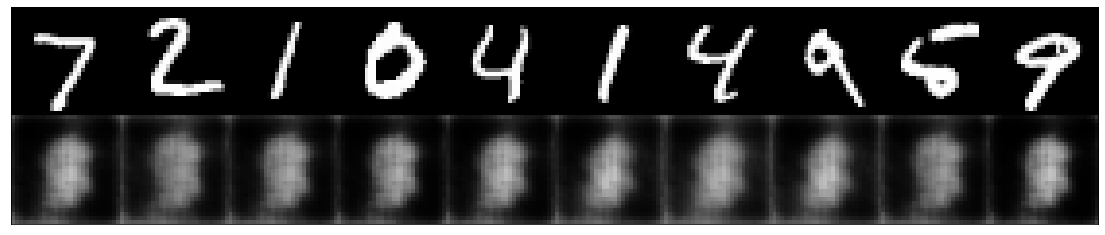


Epoch 2/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1512 - val_loss: 0.1421
Epoch 3/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1392 - val_loss: 0.1368
Epoch 4/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1351 - val_loss: 0.1330
Epoch 5/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1310 - val_loss: 0.1290
Epoch 6/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1278 - val_loss: 0.1264


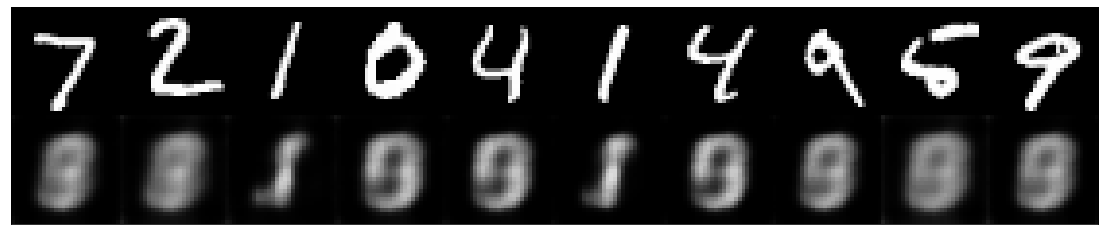

Epoch 7/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1258 - val_loss: 0.1248
Epoch 8/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1244 - val_loss: 0.1236
Epoch 9/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1231 - val_loss: 0.1224
Epoch 10/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1219 - val_loss: 0.1213
Epoch 11/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1210 - val_loss: 0.1204


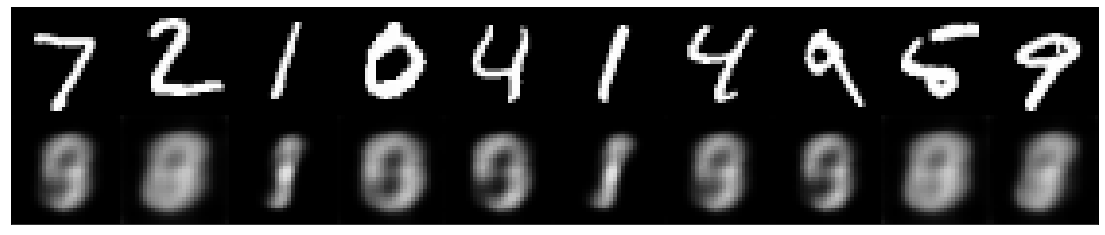

Epoch 12/200
60000/60000 [==============================] - 11s 182us/step - loss: 0.1201 - val_loss: 0.1197
Epoch 13/200
60000/60000 [==============================] - 11s 182us/step - loss: 0.1194 - val_loss: 0.1190
Epoch 14/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1188 - val_loss: 0.1186
Epoch 15/200
60000/60000 [==============================] - 11s 182us/step - loss: 0.1183 - val_loss: 0.1180
Epoch 16/200
60000/60000 [==============================] - 11s 182us/step - loss: 0.1179 - val_loss: 0.1176


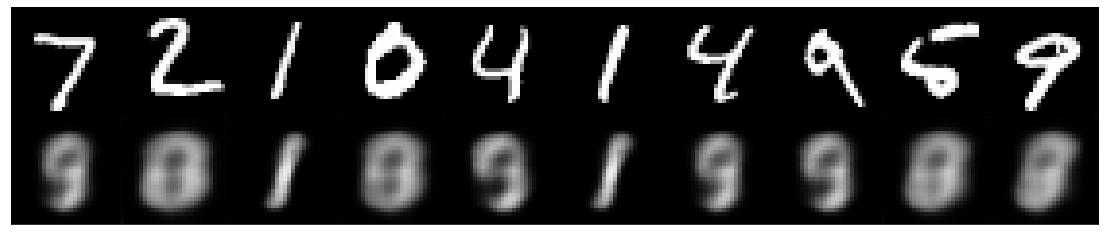

Epoch 17/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1174 - val_loss: 0.1172
Epoch 18/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1171 - val_loss: 0.1169
Epoch 19/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1167 - val_loss: 0.1165
Epoch 20/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1164 - val_loss: 0.1161
Epoch 21/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1161 - val_loss: 0.1158


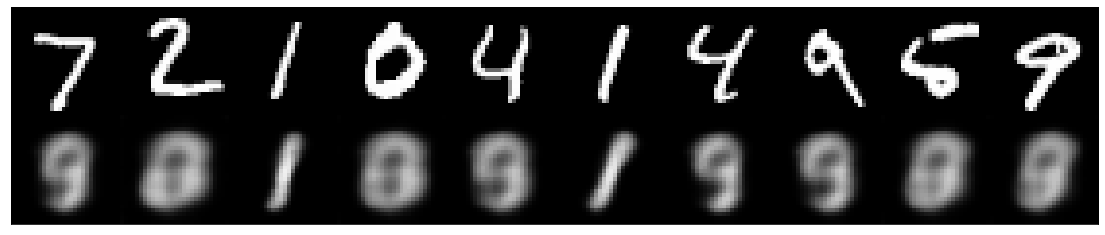

Epoch 22/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1158 - val_loss: 0.1156
Epoch 23/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1155 - val_loss: 0.1153
Epoch 24/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1152 - val_loss: 0.1150
Epoch 25/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1149 - val_loss: 0.1147
Epoch 26/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1146 - val_loss: 0.1145


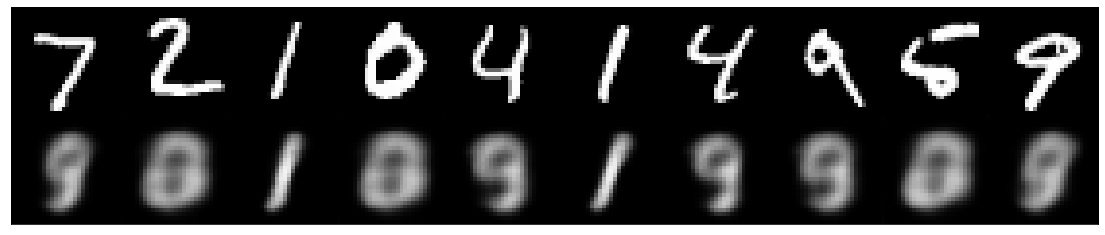

Epoch 27/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1143 - val_loss: 0.1141
Epoch 28/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1140 - val_loss: 0.1138
Epoch 29/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1137 - val_loss: 0.1136
Epoch 30/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1134 - val_loss: 0.1133
Epoch 31/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1132 - val_loss: 0.1130


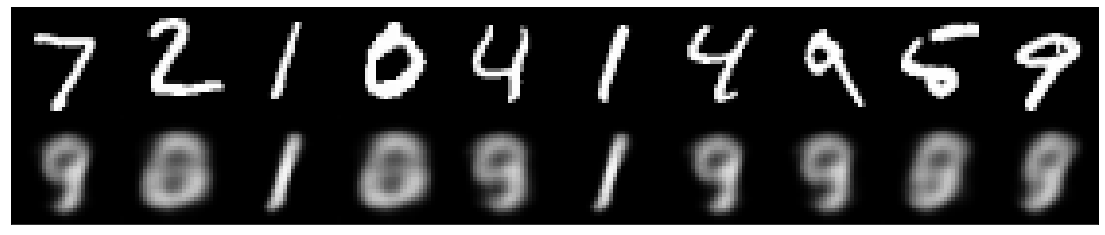

Epoch 32/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1129 - val_loss: 0.1127
Epoch 33/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1126 - val_loss: 0.1125
Epoch 34/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1124 - val_loss: 0.1123
Epoch 35/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1121 - val_loss: 0.1121
Epoch 36/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1119 - val_loss: 0.1118


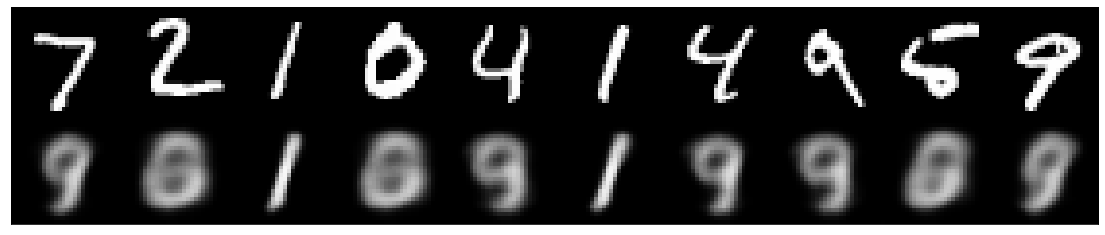

Epoch 37/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1117 - val_loss: 0.1115
Epoch 38/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1114 - val_loss: 0.1114
Epoch 39/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1112 - val_loss: 0.1112
Epoch 40/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1110 - val_loss: 0.1109
Epoch 41/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1108 - val_loss: 0.1107


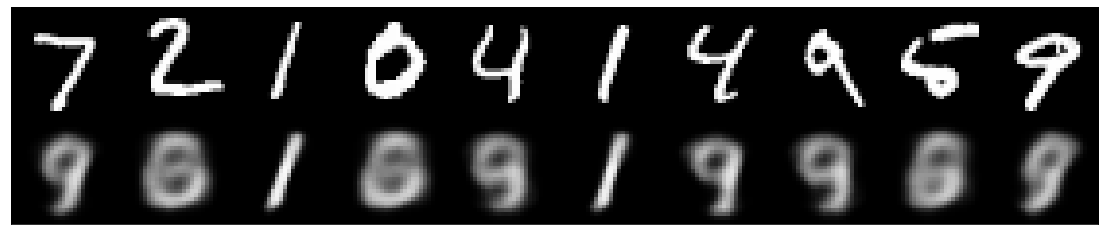

Epoch 42/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1106 - val_loss: 0.1105
Epoch 43/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1104 - val_loss: 0.1104
Epoch 44/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1102 - val_loss: 0.1102
Epoch 45/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1100 - val_loss: 0.1100
Epoch 46/200
60000/60000 [==============================] - 11s 188us/step - loss: 0.1098 - val_loss: 0.1098


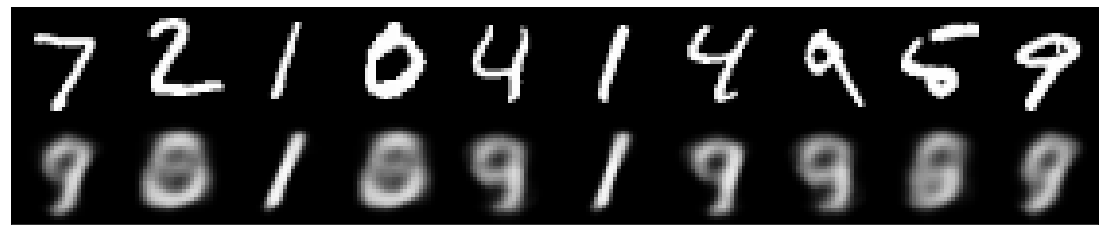

Epoch 47/200
60000/60000 [==============================] - 11s 188us/step - loss: 0.1096 - val_loss: 0.1096
Epoch 48/200
60000/60000 [==============================] - 11s 187us/step - loss: 0.1095 - val_loss: 0.1095
Epoch 49/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1093 - val_loss: 0.1093
Epoch 50/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1092 - val_loss: 0.1091
Epoch 51/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1090 - val_loss: 0.1090


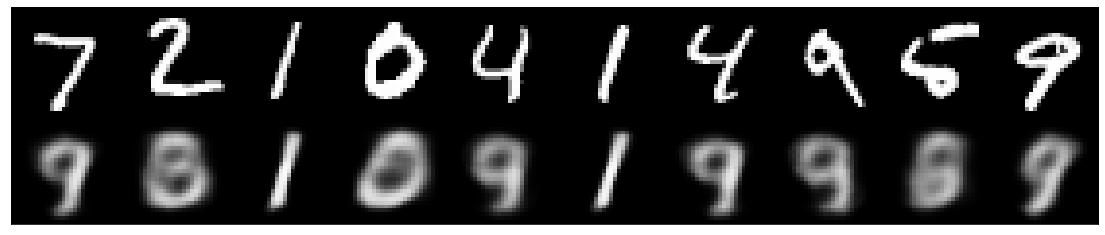

Epoch 52/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1088 - val_loss: 0.1088
Epoch 53/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1087 - val_loss: 0.1087
Epoch 54/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1085 - val_loss: 0.1085
Epoch 55/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1084 - val_loss: 0.1084
Epoch 56/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1082 - val_loss: 0.1082


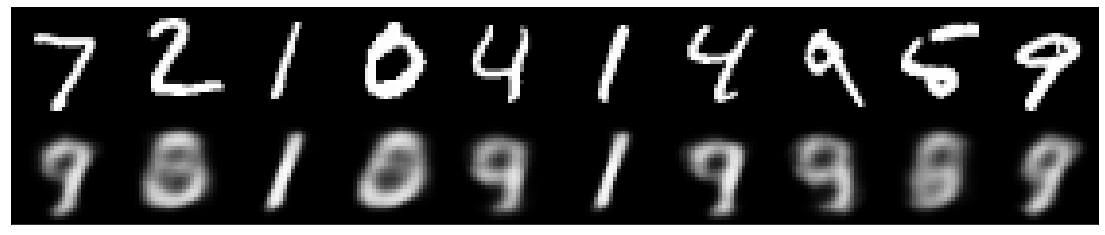

Epoch 57/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1081 - val_loss: 0.1081
Epoch 58/200
60000/60000 [==============================] - 11s 184us/step - loss: 0.1080 - val_loss: 0.1080
Epoch 59/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1079 - val_loss: 0.1080
Epoch 60/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1077 - val_loss: 0.1078
Epoch 61/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1077 - val_loss: 0.1077


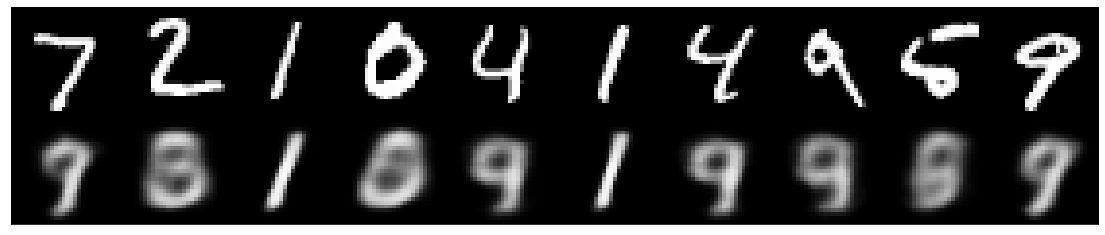

Epoch 62/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1075 - val_loss: 0.1076
Epoch 63/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1074 - val_loss: 0.1075
Epoch 64/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1073 - val_loss: 0.1074
Epoch 65/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1072 - val_loss: 0.1075
Epoch 66/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1072 - val_loss: 0.1072


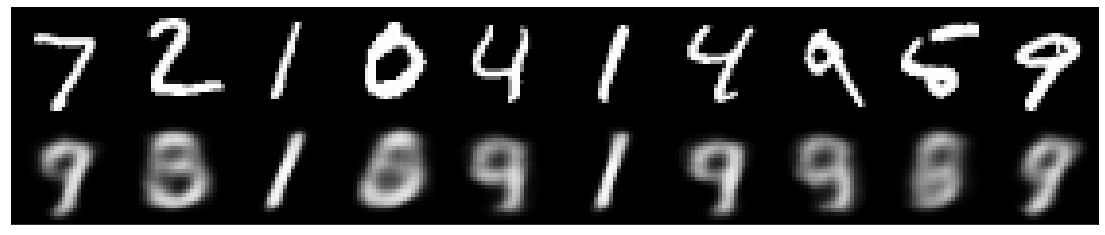

Epoch 67/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1071 - val_loss: 0.1071
Epoch 68/200
60000/60000 [==============================] - 11s 185us/step - loss: 0.1070 - val_loss: 0.1071
Epoch 69/200
60000/60000 [==============================] - 11s 186us/step - loss: 0.1069 - val_loss: 0.1069
Epoch 70/200
60000/60000 [==============================] - 11s 183us/step - loss: 0.1068 - val_loss: 0.1069
Epoch 71/200
60000/60000 [==============================] - 18s 308us/step - loss: 0.1067 - val_loss: 0.1068


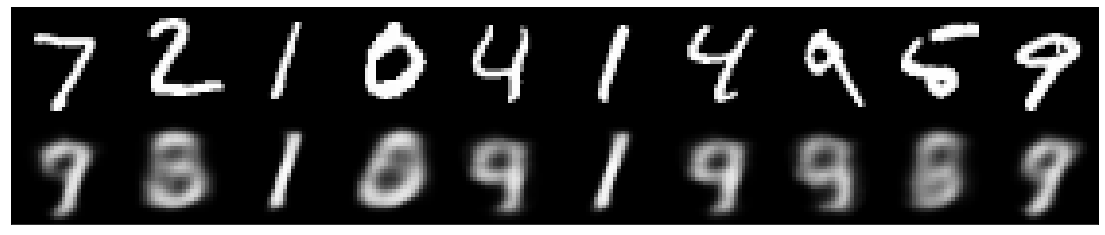

Epoch 72/200
60000/60000 [==============================] - 25s 414us/step - loss: 0.1067 - val_loss: 0.1068
Epoch 73/200
60000/60000 [==============================] - 23s 391us/step - loss: 0.1066 - val_loss: 0.1067
Epoch 74/200
60000/60000 [==============================] - 23s 390us/step - loss: 0.1065 - val_loss: 0.1067
Epoch 75/200
60000/60000 [==============================] - 28s 470us/step - loss: 0.1065 - val_loss: 0.1066
Epoch 76/200
60000/60000 [==============================] - 25s 424us/step - loss: 0.1064 - val_loss: 0.1065


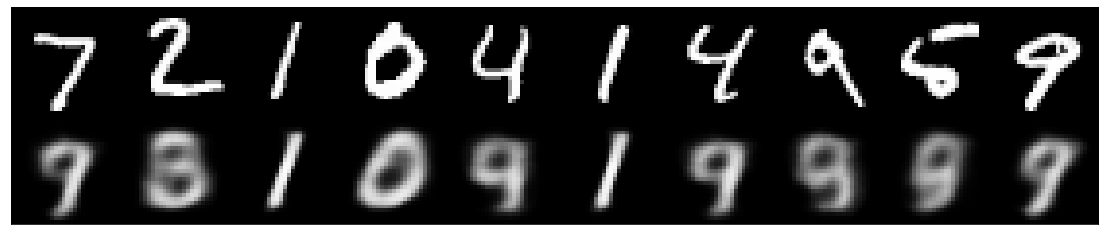

Epoch 77/200
60000/60000 [==============================] - 26s 436us/step - loss: 0.1063 - val_loss: 0.1064
Epoch 78/200
60000/60000 [==============================] - 24s 408us/step - loss: 0.1063 - val_loss: 0.1064
Epoch 79/200
60000/60000 [==============================] - 27s 449us/step - loss: 0.1062 - val_loss: 0.1063
Epoch 80/200
60000/60000 [==============================] - 26s 428us/step - loss: 0.1061 - val_loss: 0.1063
Epoch 81/200
60000/60000 [==============================] - 28s 460us/step - loss: 0.1061 - val_loss: 0.1062


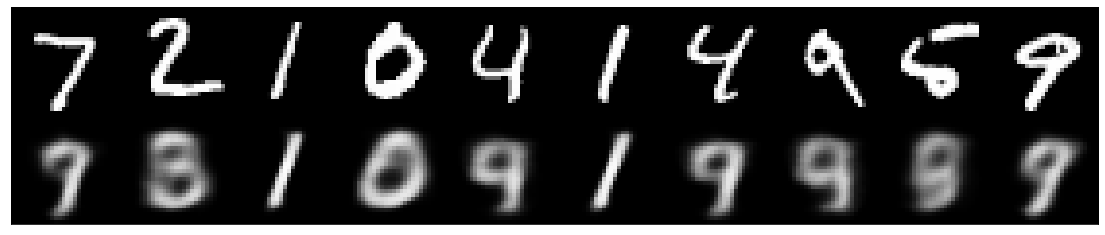

Epoch 82/200
60000/60000 [==============================] - 25s 413us/step - loss: 0.1060 - val_loss: 0.1061
Epoch 83/200
60000/60000 [==============================] - 23s 391us/step - loss: 0.1060 - val_loss: 0.1061
Epoch 84/200
60000/60000 [==============================] - 24s 403us/step - loss: 0.1059 - val_loss: 0.1060
Epoch 85/200
60000/60000 [==============================] - 28s 466us/step - loss: 0.1058 - val_loss: 0.1059
Epoch 86/200
60000/60000 [==============================] - 26s 427us/step - loss: 0.1058 - val_loss: 0.1059


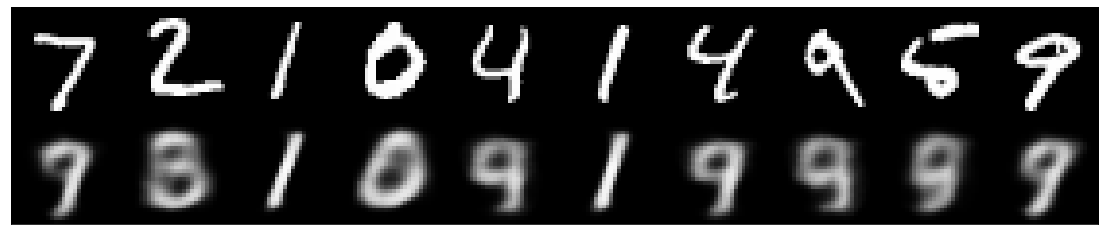

Epoch 87/200
60000/60000 [==============================] - 24s 405us/step - loss: 0.1057 - val_loss: 0.1058
Epoch 88/200
60000/60000 [==============================] - 27s 451us/step - loss: 0.1057 - val_loss: 0.1058
Epoch 89/200
60000/60000 [==============================] - 23s 386us/step - loss: 0.1057 - val_loss: 0.1058
Epoch 90/200
60000/60000 [==============================] - 25s 419us/step - loss: 0.1056 - val_loss: 0.1057
Epoch 91/200
60000/60000 [==============================] - 25s 409us/step - loss: 0.1055 - val_loss: 0.1056


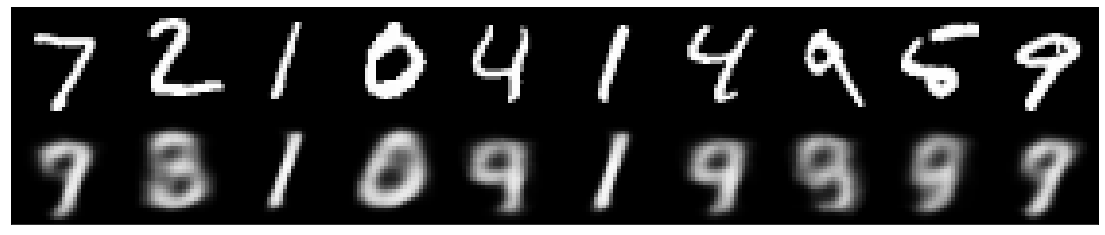

Epoch 92/200
60000/60000 [==============================] - 26s 440us/step - loss: 0.1055 - val_loss: 0.1056
Epoch 93/200
60000/60000 [==============================] - 24s 394us/step - loss: 0.1054 - val_loss: 0.1055
Epoch 94/200
60000/60000 [==============================] - 26s 432us/step - loss: 0.1054 - val_loss: 0.1055
Epoch 95/200
60000/60000 [==============================] - 27s 443us/step - loss: 0.1053 - val_loss: 0.1054
Epoch 96/200
60000/60000 [==============================] - 30s 493us/step - loss: 0.1053 - val_loss: 0.1053


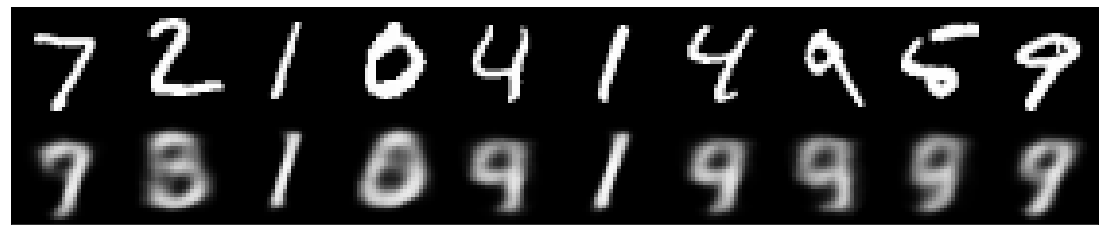

Epoch 97/200
60000/60000 [==============================] - 23s 388us/step - loss: 0.1052 - val_loss: 0.1053
Epoch 98/200
60000/60000 [==============================] - 24s 404us/step - loss: 0.1052 - val_loss: 0.1053
Epoch 99/200
60000/60000 [==============================] - 27s 445us/step - loss: 0.1051 - val_loss: 0.1052
Epoch 100/200
60000/60000 [==============================] - 25s 422us/step - loss: 0.1051 - val_loss: 0.1052
Epoch 101/200
60000/60000 [==============================] - 25s 419us/step - loss: 0.1051 - val_loss: 0.1051


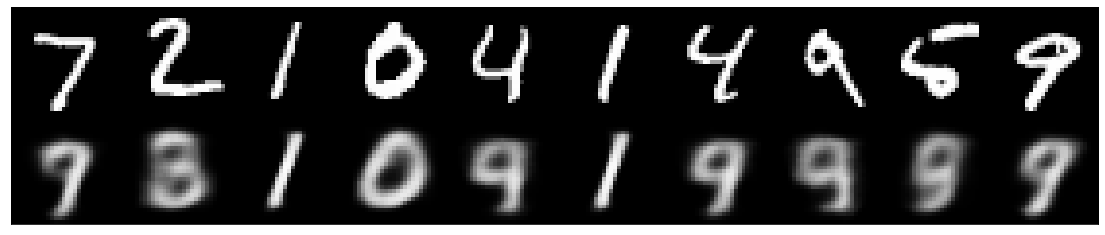

Epoch 102/200
60000/60000 [==============================] - 26s 434us/step - loss: 0.1050 - val_loss: 0.1051
Epoch 103/200
60000/60000 [==============================] - 24s 407us/step - loss: 0.1050 - val_loss: 0.1050
Epoch 104/200
60000/60000 [==============================] - 24s 401us/step - loss: 0.1049 - val_loss: 0.1051
Epoch 105/200
60000/60000 [==============================] - 24s 392us/step - loss: 0.1049 - val_loss: 0.1049
Epoch 106/200
60000/60000 [==============================] - 25s 424us/step - loss: 0.1048 - val_loss: 0.1048


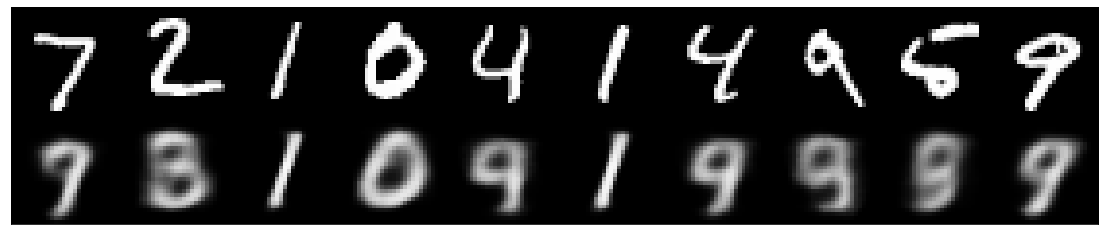

Epoch 107/200
60000/60000 [==============================] - 25s 421us/step - loss: 0.1047 - val_loss: 0.1048
Epoch 108/200
60000/60000 [==============================] - 25s 416us/step - loss: 0.1047 - val_loss: 0.1048
Epoch 109/200
60000/60000 [==============================] - 25s 415us/step - loss: 0.1047 - val_loss: 0.1047
Epoch 110/200
60000/60000 [==============================] - 25s 423us/step - loss: 0.1046 - val_loss: 0.1046
Epoch 111/200
60000/60000 [==============================] - 25s 420us/step - loss: 0.1046 - val_loss: 0.1046


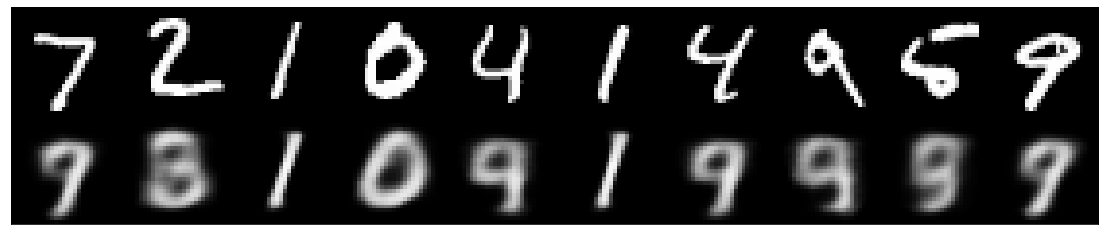

Epoch 112/200
60000/60000 [==============================] - 22s 358us/step - loss: 0.1046 - val_loss: 0.1046
Epoch 113/200
60000/60000 [==============================] - 24s 407us/step - loss: 0.1045 - val_loss: 0.1045
Epoch 114/200
60000/60000 [==============================] - 26s 433us/step - loss: 0.1045 - val_loss: 0.1045
Epoch 115/200
60000/60000 [==============================] - 26s 431us/step - loss: 0.1044 - val_loss: 0.1044
Epoch 116/200
60000/60000 [==============================] - 27s 455us/step - loss: 0.1044 - val_loss: 0.1044


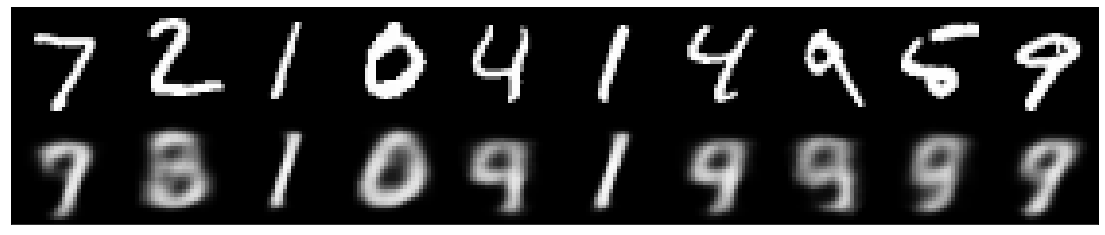

Epoch 117/200
60000/60000 [==============================] - 28s 468us/step - loss: 0.1043 - val_loss: 0.1044
Epoch 118/200
60000/60000 [==============================] - 26s 439us/step - loss: 0.1043 - val_loss: 0.1043
Epoch 119/200
60000/60000 [==============================] - 29s 488us/step - loss: 0.1042 - val_loss: 0.1042
Epoch 120/200
60000/60000 [==============================] - 26s 429us/step - loss: 0.1042 - val_loss: 0.1042
Epoch 121/200
60000/60000 [==============================] - 25s 416us/step - loss: 0.1041 - val_loss: 0.1042


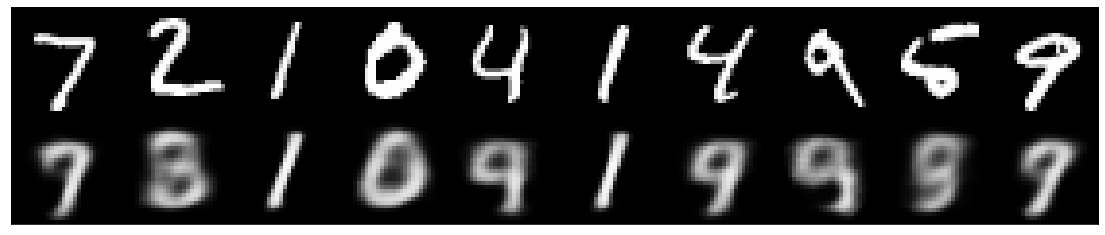

Epoch 122/200
60000/60000 [==============================] - 25s 410us/step - loss: 0.1041 - val_loss: 0.1042
Epoch 123/200
60000/60000 [==============================] - 26s 429us/step - loss: 0.1040 - val_loss: 0.1040
Epoch 124/200
60000/60000 [==============================] - 25s 415us/step - loss: 0.1040 - val_loss: 0.1040
Epoch 125/200
60000/60000 [==============================] - 23s 383us/step - loss: 0.1040 - val_loss: 0.1039
Epoch 126/200
60000/60000 [==============================] - 25s 410us/step - loss: 0.1039 - val_loss: 0.1038


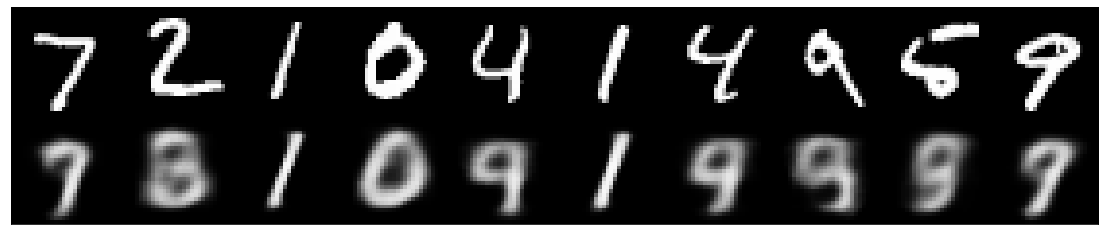

Epoch 127/200
60000/60000 [==============================] - 25s 409us/step - loss: 0.1039 - val_loss: 0.1039
Epoch 128/200
60000/60000 [==============================] - 28s 465us/step - loss: 0.1038 - val_loss: 0.1038
Epoch 129/200
60000/60000 [==============================] - 25s 421us/step - loss: 0.1038 - val_loss: 0.1037
Epoch 130/200
60000/60000 [==============================] - 24s 399us/step - loss: 0.1037 - val_loss: 0.1037
Epoch 131/200
60000/60000 [==============================] - 27s 443us/step - loss: 0.1037 - val_loss: 0.1037


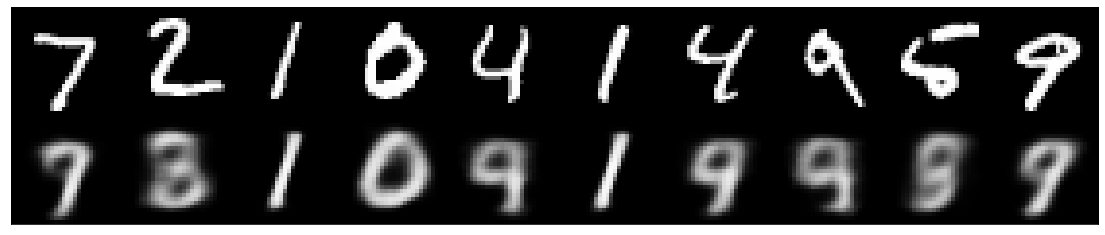

Epoch 132/200
60000/60000 [==============================] - 25s 419us/step - loss: 0.1036 - val_loss: 0.1037
Epoch 133/200
60000/60000 [==============================] - 26s 431us/step - loss: 0.1036 - val_loss: 0.1037
Epoch 134/200
60000/60000 [==============================] - 24s 402us/step - loss: 0.1036 - val_loss: 0.1035
Epoch 135/200
60000/60000 [==============================] - 24s 396us/step - loss: 0.1036 - val_loss: 0.1037
Epoch 136/200
60000/60000 [==============================] - 27s 443us/step - loss: 0.1035 - val_loss: 0.1036


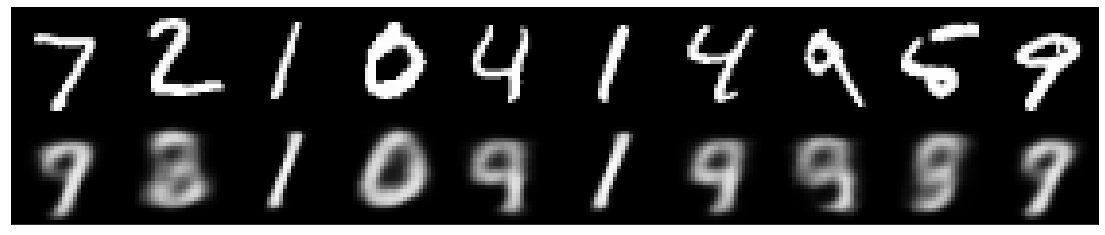

Epoch 137/200
60000/60000 [==============================] - 24s 400us/step - loss: 0.1035 - val_loss: 0.1035
Epoch 138/200
60000/60000 [==============================] - 24s 408us/step - loss: 0.1034 - val_loss: 0.1035
Epoch 139/200
60000/60000 [==============================] - 24s 392us/step - loss: 0.1034 - val_loss: 0.1034
Epoch 140/200
60000/60000 [==============================] - 26s 435us/step - loss: 0.1034 - val_loss: 0.1033
Epoch 141/200
24500/60000 [===========>..................] - ETA: 11s - loss: 0.1032

KeyboardInterrupt: 

In [11]:
from keras.callbacks import LambdaCallback, TensorBoard

epochs_to_check = np.arange(0., 200.0, 5).astype('int')

latent_distrs = []
epochs = []
imgs = x_test[:batch_size]
n_compare = 10


def on_epoch_end(epoch, logs):
    if epoch in epochs_to_check:
        decoded = vae_model.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])
        
        epochs.append(epoch)
        latent_distrs.append(z_meaner.predict(x_test, batch_size))

        
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
tb     = TensorBoard(log_dir='./logs')

vae_model.fit(x_train, x_train,
              shuffle=True,
              epochs=200,
              batch_size=batch_size,
              validation_data=(x_test, x_test),
              callbacks=[pltfig, tb],
              verbose=1)

### Try to decode random codes

In [ ]:
codes = np.random.randn(n_compare, latent_dim)
decoded_from_codes = vae_decoder.predict(codes, batch_size=n_compare)
plot_digits(decoded_from_codes)

## Save models

In [ ]:
import os
import json

save_path = os.path.join("saved_models", "convolutional_vae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "vae_2_ldim_200_epochs.json"), "w") as f:
    json.dump(vae_model.to_json(), f, indent=4)
vae_model.save_weights(os.path.join(save_path, "vae_2_ldim_200_epochs.h5"))

with open(os.path.join(save_path, "vae_encoder_2_ldim_200_epochs.json"), "w") as f:
    json.dump(vae_encoder.to_json(), f, indent=4)
vae_encoder.save_weights(os.path.join(save_path, "vae_encoder_2_ldim_200_epochs.h5"))

with open(os.path.join(save_path, "z_meaner_2_ldim_200_epochs.json"), "w") as f:
    json.dump(z_meaner.to_json(), f, indent=4)
z_meaner.save_weights(os.path.join(save_path, "z_meaner_2_ldim_200_epochs.h5"))

with open(os.path.join(save_path, "z_log_varer_2_ldim_200_epochs.json"), "w") as f:
    json.dump(z_log_varer.to_json(), f, indent=4)
z_log_varer.save_weights(os.path.join(save_path, "z_log_varer_2_ldim_200_epochs.h5"))

with open(os.path.join(save_path, "vae_decoder_2_ldim_200_epochs.json"), "w") as f:
    json.dump(vae_decoder.to_json(), f, indent=4)
vae_decoder.save_weights(os.path.join(save_path, "vae_decoder_2_ldim_200_epochs.h5"))

# Draw the manifold

In [ ]:
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import cm


def make_2d_scatter_gif(fname, fig):
    plt.title("MANIFOLD\nEpoch: {}".format(epochs[0]))
    im = plt.scatter(latent_distrs[0][:, 0], latent_distrs[0][:, 1], c=y_test, cmap=cm.coolwarm)
    plt.colorbar()

    def update(i):
        fig.clear()
        im = plt.scatter(latent_distrs[i][:, 0], latent_distrs[i][:, 1], c=y_test, cmap=cm.coolwarm)
        im.axes.set_title("MANIFOLD\nEpoch: {}".format(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        plt.legend(loc='upper right')

        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(latent_distrs)), interval=150)
    anim.save(fname, dpi=80, writer="imagemagick")

In [ ]:
import os


gif_file_path = "./figs4/z_distr_conv_vae_2_ldim_200_epochs.gif"
if not os.path.exists(os.path.dirname(gif_file_path)):
    os.mkdir(os.path.dirname(gif_file_path))
    
make_2d_scatter_gif(gif_file_path, plt.figure(figsize=(7,7)))